In [36]:
#visualization
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
from lion_pytorch import Lion


#scraping from internet
from PIL import Image
#scraping from internet
import requests
from io import BytesIO
# time related
from timeit import default_timer as timer
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler


In [2]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=.5)
])

In [3]:
trainset = torchvision.datasets.ImageFolder("archive/train", transform = transforms)
validset = torchvision.datasets.ImageFolder("archive/valid", transform = transforms)
testset = torchvision.datasets.ImageFolder("archive/test", transform = transforms)

In [4]:
BATCH_SIZE= 128
batch_size = 128

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

In [5]:
images,labels = next(iter(trainloader))
images,labels = images.numpy(), labels.numpy

TypeError: 'builtin_function_or_method' object is not subscriptable

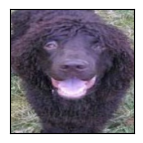

In [9]:
fig = plt.figure(figsize = (15,5))

for i in range(int(batch_size/8)):
    ax = fig.add_subplot(2 , int(batch_size/16) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i],(1,2,0)),cmap = 'gray')
    ax.set_title(trainset.classes[labels[i]])

In [10]:
# Single batch
print("number of train batches : ", len(trainloader))
print("number of validation batches : ", len(validloader))
print("Size of test batches : ", len(testloader))

number of train batches :  63
number of validation batches :  6
Size of test batches :  6


In [11]:
print("Classes : ", trainset.classes)


Classes :  ['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']


In [12]:
model = torchvision.models.resnet18(weights = True)# Use ResNet 18

In [13]:
#freeze model params
for param in model.parameters():
    param = param.requires_grad_(False)


In [14]:
model.fc = nn.Sequential(
                      nn.Linear(model.fc.in_features, 256),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(256, len(trainset.classes)), # change output to match size of dataset               
                      nn.LogSoftmax(dim=1))


In [15]:
print("The new layer is : ",model.fc)

The new layer is :  Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=70, bias=True)
  (4): LogSoftmax(dim=1)
)


In [16]:
device= 'mps'

In [17]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
lr = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer = Lion(model.parameters() , lr = lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [21]:
#format class

class color_formats:
    """
    Simple color formating:
    Variables:
        >OKCYAN - cyan printing.
        >Bold - bold printing.
        >UNDERLINE - underline printing.
    """
    OKCYAN = '\033[96m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [22]:
model.epochs = 0 

In [23]:
device = 'mps'

In [53]:
import pandas as pd
from timeit import default_timer as timer

def train_loop(
        model,
        criterion,
        optimizer,
        train_loader,
        valid_loader,
        save_model_name,
        max_epochs_stop,
        num_epochs,
        num_epochs_report
):
    """
    Args:
        model (PyTorch nn model): The neural network for the training process.
        criterion (PyTorch loss function): Initialize the loss function.
        optimizer (PyTorch optimizer): Use an optimizer to compute gradients to update the weights.
        train_loader (PyTorch dataloader): training dataloader to iterate through.
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping.
        save_model_name (str): file path to save the model state dict, file name ends with 'pt.'
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping.
        num_epochs (int): maximum number of training epochs if the early stopping is not activated.
        num_epochs_report (int): frequency of epochs to print training reports.

    Returns:
        model (PyTorch model): Trained neural networks with best weights.
        history (DataFrame): History of train and validation loss and accuracy.
    """
    # Init early stopping
    epochs_no_improvement = 0
    valid_loss_min = np.inf
    valid_best_acc = 0
    history = []
    overall_start = timer()

    for epoch in range(num_epochs):
        # Init train, valid loss, and accuracy
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0
        valid_acc = 0

        model.train()
        start = timer()

        for idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.long())
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            print(
                f"Epoch: {epoch + 1}\t{100 * (idx + 1) // len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch",
                end='\r'
            )
        else:
            model.epochs += 1

            with torch.no_grad():
                model.eval()
                for data, target in valid_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target.long())
                    valid_loss += loss.item() * data.size(0)

                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor)
                    )
                    valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results for the num_epochs_report that was set
            if (epoch + 1) % num_epochs_report == 0:
                print(
                    f'\n\nEpoch: {color_formats.BOLD}{epoch + 1}{color_formats.ENDC} \tTraining Loss: {color_formats.BOLD}{train_loss:.4f}{color_formats.ENDC} \tValidation Loss: {color_formats.BOLD}{valid_loss:.4f}{color_formats.ENDC}'
                )
                print(
                    f'\t\tTraining Accuracy: {color_formats.BOLD}{100 * train_acc:.2f}%{color_formats.ENDC}\t Validation Accuracy: {color_formats.BOLD}{100 * valid_acc:.2f}%{color_formats.ENDC}\n'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_model_name)
                # Track improvement
                epochs_no_improvement = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch + 1

            # Otherwise count all consecutive epochs with no improvement.
            else:
                epochs_no_improvement += 1

                if epochs_no_improvement >= max_epochs_stop:
                    print(
                        f'\n\n{color_formats.OKCYAN}Early stopping activated!{color_formats.ENDC}\nthe validation loss has not improved for {max_epochs_stop} epochs.\n\n{color_formats.BOLD + color_formats.UNDERLINE}End of training report:{color_formats.ENDC}\n\n\t-Total epochs: {epoch + 1} \n\t-Best epoch: {color_formats.BOLD}{best_epoch}{color_formats.ENDC} \n\t-loss: {color_formats.BOLD}{valid_loss_min:.2f}{color_formats.ENDC} \n\t-accuracy: {color_formats.BOLD}{100 * valid_best_acc:.2f}%\n{color_formats.ENDC}'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch + 1):.2f} seconds per epoch.'
                    )
                    model.load_state_dict(torch.load(save_model_name))
                    model.optimizer = optimizer
                    # History update
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    return model, history
            scheduler.step(valid_loss)
    # Record overall time and print out Report
    total_time = timer() - overall_start
    print(
        f'\nBest epoch is epoch #{best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # History update
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history


### This is the old code, might have indentation issues

def train_loop(
        model,
        criterion,
        optimizer,
        train_loader,
        valid_loader,
        save_model_name,
        max_epochs_stop = 3,
        num_epochs  = 50,
        num_epochs_report =1
):
    

    """
    Args
        --------
            >model (Pytorch nn model): The neural network for the training process.  
            >criterion (Pytorch loss function): Initialize the loss function.
            >optimizer (Pytorch optimizer): Use an optimizer to compute gradients to update the weights.
            >train_loader (Pytorch dataloader): training dataloader to iterate through.
            >valid_loader (Pytorch dataloader): validation dataloader used for early stopping.
            >save_model_name (str): file path to save the model state dict, file name ends with 'pt.'.
            >max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping.
            >num_epochs (int): maximum number of training epochs if the early stopping is not activated.
            >num_epochs_report (int): frequency of epochs to print training reports.
        
        outputs
        --------
            >model (PyTorch model): Trained neural networks with best weights.
            >history (DataFrame): History of train and validation loss and accuracy.

    """


    #Init early stopping

    epochs_no_imporve = 0
    valid_loss_min = np.inf

    valid_max_acc = 0
    history = []

    overall_start = timer()

    for epoch in range(num_epochs):
        #init train,valid loss and accuracy

        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0
        valid_acc = 0

        model.train()
        start = timer()

        for idx,(data,target) in enumerate(train_loader):
            data,target = data.to(device),target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target.long())
            loss.backward()

            optimizer.step()

            train_loss += loss.item() * data.size(0)

           # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            print(
                f"Epoch: {epoch+1}\t{100*(idx +1) // len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch",
                end = '\r'
            )
        else:
            model.epochs += 1 

            with torch.no_grad():
                model.eval()
                for data,target in valid_loader:
                    data,target = data.to(device),target.to(device)

                output = model(data)
                loss  =  criterion(output,target.long())
                valid_loss += loss.item() * data.size(0)

                _,pred = torch.max(output,dim = 1)

                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor)
                )
                valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

             # Print training and validation results for the num_epochs_report that was set
            if (epoch + 1) % num_epochs_report == 0:
                    print(
                        f'\n\nEpoch: {color_formats.BOLD}{epoch+1}{color_formats.ENDC} \tTraining Loss: {color_formats.BOLD}{train_loss:.4f}{color_formats.ENDC} \tValidation Loss: {color_formats.BOLD}{valid_loss:.4f}{color_formats.ENDC}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {color_formats.BOLD}{100 * train_acc:.2f}%{color_formats.ENDC}\t Validation Accuracy: {color_formats.BOLD}{100 * valid_acc:.2f}%{color_formats.ENDC}\n'
                    )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_model_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch + 1

            # Otherwise count all consecutive epochs with no improvement.
            else:
                 epochs_no_imporve += 1

                 if epochs_no_imporve>= max_epochs_stop:
                      print(
                            f'\n\n{color_formats.OKCYAN}Early stopping activated!{color_formats.ENDC}\nthe validation loss has not improved for {max_epochs_stop} epochs.\n\n{color_formats.BOLD + color_formats.UNDERLINE}End of training report:{color_formats.ENDC}\n\n\t-Total epochs: {epoch+1} \n\t-Best epoch: {color_formats.BOLD}{best_epoch}{color_formats.ENDC} \n\t-loss: {color_formats.BOLD}{valid_loss_min:.2f}{color_formats.ENDC} \n\t-accuracy: {color_formats.BOLD}{100 * valid_best_acc:.2f}%\n{color_formats.ENDC}'
                        )
                      total_time = timer() - overall_start
                      print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )
                      model.load_state_dict(torch.load(save_model_name))
                      model.optimizer = optimizer
                      # History update
                      history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                      return model, history
    # Record overall time and print out Report
    total_time = timer() - overall_start
    print(
        f'\nBest epoch is epoch #{best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # History update
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [54]:
# Running the model
model, history = train_loop(
    model,
    criterion,
    optimizer,
    trainloader,
    validloader,
    save_model_name="./model1.pt",
    max_epochs_stop=10,
    num_epochs=300,
    num_epochs_report=3)

/Users/hanli/miniforge3/envs/ds/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 3	100.00% complete. 25.51 seconds elapsed in epoch

Epoch: 3 	Training Loss: 0.7558 	Validation Loss: 0.6446
		Training Accuracy: 77.41%	 Validation Accuracy: 89.43%

Epoch: 6	100.00% complete. 26.13 seconds elapsed in epoch

Epoch: 6 	Training Loss: 0.6977 	Validation Loss: 0.6320
		Training Accuracy: 79.32%	 Validation Accuracy: 88.71%

Epoch: 9	100.00% complete. 25.48 seconds elapsed in epoch

Epoch: 9 	Training Loss: 0.6775 	Validation Loss: 0.6413
		Training Accuracy: 79.79%	 Validation Accuracy: 89.57%

Epoch: 12	100.00% complete. 25.91 seconds elapsed in epoch

Epoch: 12 	Training Loss: 0.6322 	Validation Loss: 0.6358
		Training Accuracy: 81.06%	 Validation Accuracy: 90.29%

Epoch: 15	100.00% complete. 24.44 seconds elapsed in epoch

Epoch: 15 	Training Loss: 0.6061 	Validation Loss: 0.6168
		Training Accuracy: 81.87%	 Validation Accuracy: 91.14%

Epoch: 18	100.00% complete. 27.66 seconds elapsed in epoch

Epoch: 18 	Training Loss: 0.5824 	Validation Loss: 0.6135
		Traini

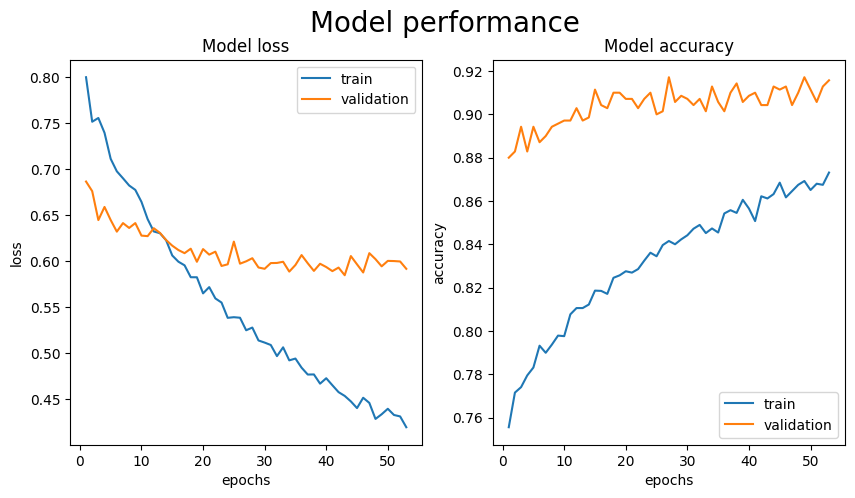

In [55]:
#models logs in detail over time of training.

history.index = [idx for idx in range(1, history.shape[0]+1)] #from first epoch
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('Model performance',  size = 20)
#ethnicity model log

axs[0].plot(history["train_loss"], label = "train")
axs[0].plot(history["valid_loss"], label = "validation")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[0].set_title('Model loss')

axs[1].plot(history["train_acc"], label = "train")
axs[1].plot(history["valid_acc"], label = "validation")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].legend()
axs[1].set_title('Model accuracy')


plt.show()

In [56]:
def Accuracy_report(loader = None, model = None, n_classes = None):
    """
    Args:
    >loader (pytorch dataloader): the data for accuracy testing.
    >model (pytorch model) : the neural network.
    >n_classes (int): the number of classes.
    
    Output: 
    > class_acc (dict) : accuracy per classes. non existant taregts in the test set are set to nan value.
    > acc (float): overall accuracy.
    """
    my_classes = []

    classes = [n_class for n_class in range(n_classes)]
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in loader:
            inputs,targets  = data
            inputs,targets  = inputs.to(device),targets.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # collect the correct predictions for each class
            for target, prediction in zip(targets, predictions):
                if target == prediction:
                    correct_pred[classes[target]] += 1
                total_pred[classes[target]] += 1
    for classname, correct_count in correct_pred.items():
            try:
                accuracy = 100 * float(correct_count) / total_pred[classname]
                my_classes.append(accuracy)
            except ZeroDivisionError:
                my_classes.append(np.nan)
                continue
    acc =  round(100 * float(sum(correct_pred.values())/sum(total_pred.values())),2)
    class_acc = dict(zip(classes,[round(mc,2) for mc in my_classes]))
    return class_acc, acc

def test_report(class_acc,acc):
    """
    Args:
        > my_classes (dict) : accuracy per classes. non existant taregts in the test set are set to nan value.
        > acc (float): overall accuracy.
    
    Output:
        >report of test performance.
    """    
    print(f"{color_formats.BOLD + color_formats.UNDERLINE}Test Accuracy Report{color_formats.ENDC}")
    for key,value in class_acc.items():
        print(f"Class {trainset.classes[key]} has achived {color_formats.BOLD}{value}%{color_formats.ENDC} accuracy\n")
    print(f"Overall accuracy: {color_formats.BOLD}{acc}%{color_formats.ENDC}")




In [57]:
m1_test_class_acc, m1_test_acc = Accuracy_report(loader = testloader,model = model, n_classes = 70)
test_report(m1_test_class_acc,m1_test_acc)


Test Accuracy Report
Class Afghan has achived 100.0% accuracy

Class African Wild Dog has achived 100.0% accuracy

Class Airedale has achived 90.0% accuracy

Class American Hairless has achived 90.0% accuracy

Class American Spaniel has achived 70.0% accuracy

Class Basenji has achived 100.0% accuracy

Class Basset has achived 100.0% accuracy

Class Beagle has achived 90.0% accuracy

Class Bearded Collie has achived 100.0% accuracy

Class Bermaise has achived 100.0% accuracy

Class Bichon Frise has achived 100.0% accuracy

Class Blenheim has achived 90.0% accuracy

Class Bloodhound has achived 80.0% accuracy

Class Bluetick has achived 100.0% accuracy

Class Border Collie has achived 100.0% accuracy

Class Borzoi has achived 90.0% accuracy

Class Boston Terrier has achived 90.0% accuracy

Class Boxer has achived 100.0% accuracy

Class Bull Mastiff has achived 100.0% accuracy

Class Bull Terrier has achived 80.0% accuracy

Class Bulldog has achived 60.0% accuracy

Class Cairn has achive

In [60]:
images, labels = next(iter(testloader))
preds = np.squeeze(model(images.to(device)).data.max(1, keepdim=True)[1].cpu().numpy())
images = images.cpu().numpy()

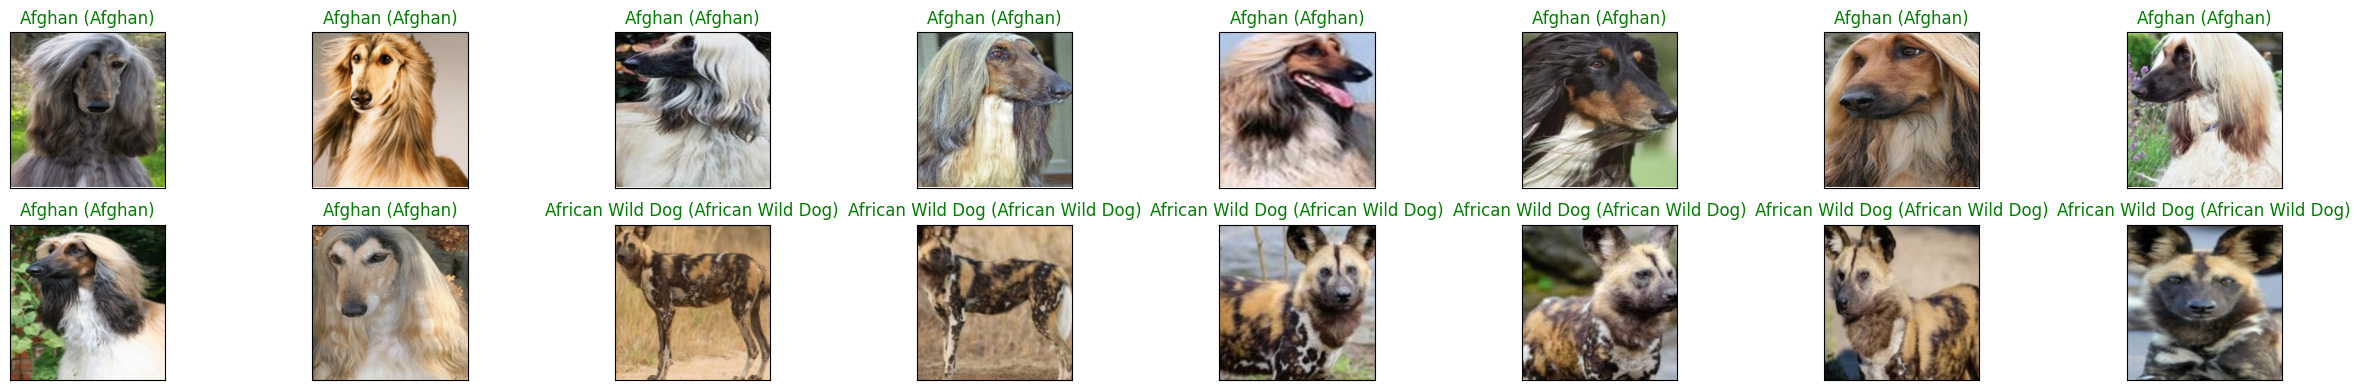

In [61]:
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(int(batch_size/8)):
    ax = fig.add_subplot(2, int(batch_size/16), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].transpose(1,2,0)), cmap='gray')
    ax.set_title("{} ({})".format(trainset.classes[preds[idx]], trainset.classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))
plt.tight_layout()

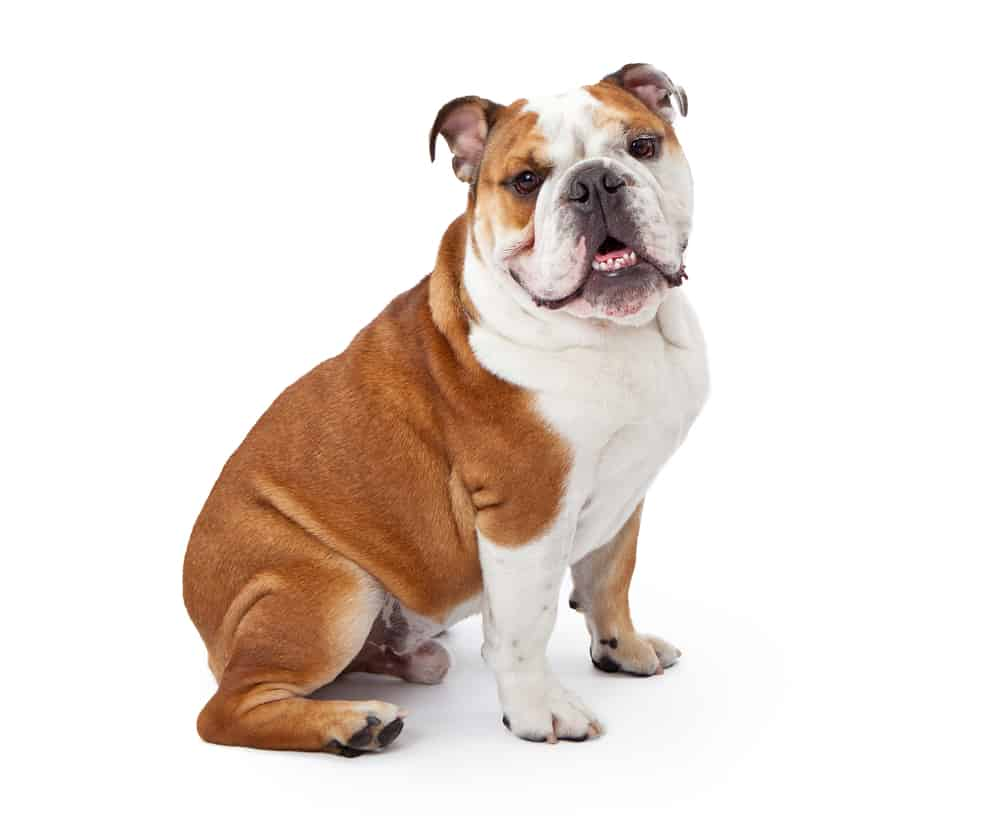

In [62]:
url = 'https://www.k9web.com/wp-content/uploads/2021/01/english-bulldog-sitting-for-a-portrait.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

In [63]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


import torch
import torchvision.transforms as transforms
import numpy as np

# Assuming you have already imported the required libraries and defined the necessary variables

transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)
])

def predictor(img, n=5):
    """
    Args:
        img: The image to predict.
        n: Number of top probabilities.

    Outputs:
        pred: The top prediction.
        top_preds: Top n predictions.
    """
    img = transforms(img).unsqueeze(0)
    img = img.to('mps')  # Assuming your model is on the GPU

    # Get the class predicted
    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output).item()
        pred = trainset.classes[pred]

        # Get model probabilities
        probs = torch.softmax(output, dim=1)
        top_probs, top_indices = torch.topk(probs, n)

        # Convert to prediction probabilities of the top n predictions
        top_probs = [f"{round(float(prob) * 100, 2)}%" for prob in top_probs.squeeze().cpu().numpy()]
        top_preds = dict(zip([trainset.classes[i] for i in top_indices.squeeze().cpu().numpy()], top_probs))

    return pred, top_preds


In [64]:
my_prediction, top_predictions = predictor(img, n=5)


In [65]:
my_prediction


'Bulldog'

In [66]:
top_predictions


{'Bulldog': '57.53%',
 'French Bulldog': '11.71%',
 'Boxer': '10.91%',
 'Boston Terrier': '8.36%',
 'Bull Mastiff': '3.1%'}